In [1]:
import numpy as np
import cv2
import os
import open3d as o3d
import matplotlib.pyplot as plt
import json

from process_bag import get_images
from utils import get_o3d_intrinsics, colordepth_to_rgbd, rgbd_to_pcd

depth_intrinsics, color_intrinsics = get_o3d_intrinsics()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_folder = "data/aligned"

In [5]:
# ply_fp = os.path.join(test_folder, "sample_color.ply")
# ply_pc = o3d.io.read_point_cloud(
#     ply_fp, remove_nan_points=False, remove_infinite_points=False)
# print(ply_pc.normals)
# # Visualize
# o3d.visualization.draw_geometries([ply_pc])

In [6]:
color_imgs, depth_imgs = get_images(
    start_idx = 0,
    end_idx = 100,
    bag_fp = os.path.join(test_folder, "color_sample.bag"),
    color_path = os.path.join(test_folder, "color.npy"),
    depth_path = os.path.join(test_folder, "depth.npy"),
    align = True,
    median = True
)
color_imgs.shape, depth_imgs.shape, color_imgs.dtype, depth_imgs.dtype

((480, 640, 3), (480, 640), dtype('uint8'), dtype('uint16'))

In [7]:
lst = []
for fp_idx in range(1, 4):
    color_imgs, depth_imgs = get_images(
        start_idx = 0,
        end_idx = 100,
        bag_fp=os.path.join(test_folder, f"test_{fp_idx}.bag"),
        color_path=os.path.join(test_folder, f"color_{fp_idx}.npy"),
        depth_path=os.path.join(test_folder, f"depth_{fp_idx}.npy"),
        align = True,
        median = True,
    )
    rgbd_image = colordepth_to_rgbd(color_imgs, depth_imgs)


    lst.append(rgbd_image)
lst[0]

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.

In [8]:
# Plot images
def plot_rgbd(rgbd_image):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(rgbd_image.color)
    ax[1].imshow(rgbd_image.depth)
    ax[0].set_title("Color image")
    ax[1].set_title("Depth image")
    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()

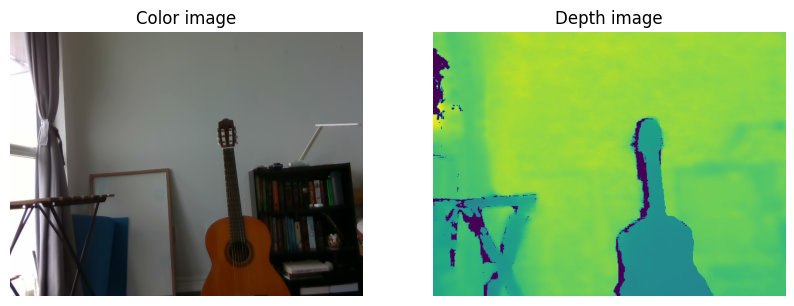

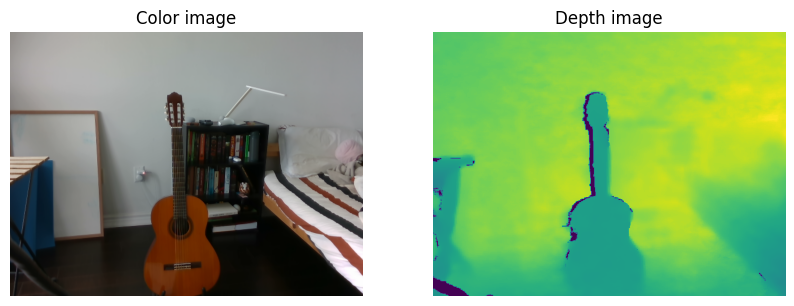

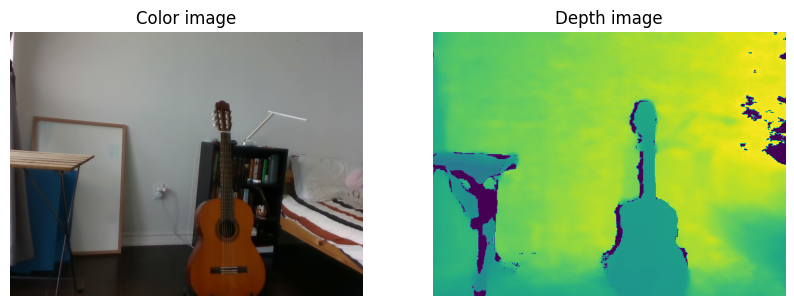

In [9]:
plot_rgbd(lst[0])
plot_rgbd(lst[1])
plot_rgbd(lst[2])

In [11]:
voxel_size = 0.02

pcds_down = []
for rgbd_image in lst:
    pcd = rgbd_to_pcd(
        rgbd_image, 
        intrinsics=color_intrinsics,
        extrinsics=np.eye(4),
        voxel_size=voxel_size
    )
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    pcds_down.append(pcd)

In [13]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
o3d.visualization.draw_geometries([*pcds_down, origin], zoom=0.5, front=[0, 0, 1], lookat=[0, 0, 1], up=[0, 1, 0])

In [16]:
# Draw a 1m x 1m x 1m cube
cube = o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
cube.translate((0, 0, -1.5))
o3d.visualization.draw_geometries([cube, *pcds_down, origin], zoom=0.5, front=[0, 0, 1], lookat=[0, 0, 1], up=[0, 1, 0])

In [18]:
# From http://www.open3d.org/docs/latest/tutorial/Advanced/multiway_registration.html
def pairwise_registration(
        source, target, max_correspondence_distance_coarse,
        max_correspondence_distance_fine
    ):
    print("Apply point-to-plane ICP")
    # Coarse ICP starting with identity matrix
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, 
        target, 
        max_correspondence_distance_coarse, 
        init = np.identity(4),
        estimation_method = o3d.pipelines.registration.TransformationEstimationPointToPlane()
    )
    # Fine ICP using the result of coarse ICP as initialization
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, 
        target, 
        max_correspondence_distance_fine,
        init = icp_coarse.transformation,
        estimation_method = o3d.pipelines.registration.TransformationEstimationPointToPlane()
    )
    
    # Return the transformation matrix and information matrix
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp


def full_registration(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], 
                pcds[target_id], 
                max_correspondence_distance_coarse,
                max_correspondence_distance_fine
            )
            print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph

In [19]:
print("Full registration ...")
max_correspondence_distance_coarse = voxel_size * 50
max_correspondence_distance_fine = voxel_size * 5
# with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Error) as cm:
    pose_graph = full_registration(pcds_down,
                                   max_correspondence_distance_coarse,
                                   max_correspondence_distance_fine)

Full registration ...
Apply point-to-plane ICP
Build o3d.pipelines.registration.PoseGraph
Apply point-to-plane ICP
Build o3d.pipelines.registration.PoseGraph
Apply point-to-plane ICP
Build o3d.pipelines.registration.PoseGraph


In [20]:
print("Optimizing PoseGraph ...")
option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0
)
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    o3d.pipelines.registration.global_optimization(
        pose_graph,
        o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option
    )

Optimizing PoseGraph ...
[Open3D DEBUG] Validating PoseGraph - finished.
[Open3D DEBUG] [GlobalOptimizationLM] Optimizing PoseGraph having 3 nodes and 3 edges.
[Open3D DEBUG] Line process weight : 238.653333
[Open3D DEBUG] [Initial     ] residual : 7.129437e+02, lambda : 2.766636e+00
[Open3D DEBUG] [Iteration 00] residual : 1.738678e+02, valid edges : 0, time : 0.000 sec.
[Open3D DEBUG] [Iteration 01] residual : 1.715697e+02, valid edges : 0, time : 0.000 sec.
[Open3D DEBUG] [Iteration 02] residual : 1.712257e+02, valid edges : 0, time : 0.000 sec.
[Open3D DEBUG] [Iteration 03] residual : 1.711627e+02, valid edges : 0, time : 0.000 sec.
[Open3D DEBUG] [Iteration 04] residual : 1.711503e+02, valid edges : 0, time : 0.000 sec.
[Open3D DEBUG] [Iteration 05] residual : 1.711478e+02, valid edges : 0, time : 0.000 sec.
[Open3D DEBUG] [Iteration 06] residual : 1.711473e+02, valid edges : 0, time : 0.000 sec.
[Open3D DEBUG] Current_residual - new_residual < 1.000000e-06 * current_residual
[Ope

In [21]:
# Transform all point clouds
for point_id in range(len(pcds_down)):
    print(pose_graph.nodes[point_id].pose)
    pcds_down[point_id].transform(pose_graph.nodes[point_id].pose)

[[ 1.00000000e+00  8.77134567e-22  3.38813179e-21  3.38813179e-21]
 [-8.29881874e-22  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.38813179e-21 -1.69406589e-21  1.00000000e+00 -1.69406589e-21]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.99976067  0.0212676  -0.00512812 -0.01326096]
 [-0.02120044  0.99969314  0.0128127  -0.00131307]
 [ 0.00539904 -0.01270092  0.99990476  0.0088413 ]
 [ 0.          0.          0.          1.        ]]
[[ 9.99765477e-01  2.16430899e-02 -7.54078540e-04 -1.71304914e-02]
 [-2.16283655e-02  9.99639527e-01  1.59069046e-02 -2.47497953e-04]
 [ 1.09808128e-03 -1.58868646e-02  9.99873193e-01  1.03102079e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [22]:
o3d.visualization.draw_geometries(
    pcds_down,
    zoom=0.5,
    front=[0, 0, 1],
    lookat=[0, 0, 1],
    up=[0, 1, 0]
)

In [16]:
# Test colmap pointcloud
ply_fp = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/colmap_results/dense/fused.ply"
colmap_pcd = o3d.io.read_point_cloud(ply_fp)
colmap_pcd = colmap_pcd.voxel_down_sample(voxel_size=0.02)
colmap_pcd

PointCloud with 21061 points.

In [19]:
np.asarray(colmap_pcd.points).dtype

dtype('float64')

In [20]:
o3d.io.write_point_cloud("tmp.ply", colmap_pcd)

True

In [3]:
# Draw camera locations and rotations
transforms_json_fp = "pointnerf/data_src/nerf/nerf_synthetic_colmap/chair/transforms_train.json"
with open(transforms_json_fp, "r") as f:
    transforms = json.load(f)

blender2opencv = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
frames = transforms["frames"]
extrinsic_matrices = [
    np.array(frame["transform_matrix"]) # @ blender2opencv
for frame in frames]

In [4]:
camera_angle = 0.6911112070083618
focal = 0.5 * 800 / np.tan(0.5 * camera_angle)
focal

1111.1110311937682

In [5]:
# Create dummy intrinsics
intrinsics = o3d.camera.PinholeCameraIntrinsic()
intrinsics.set_intrinsics(512, 512, focal, focal, 256, 256)

In [9]:
# Draw camera locations and rotations
cameras = []
for extrinsic_matrix in extrinsic_matrices:
    camera = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2)
    camera.transform(extrinsic_matrix)
    cameras.append(camera)
    # break

In [10]:
# Draw origin
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

In [11]:
o3d.visualization.draw_geometries([colmap_pcd, origin] + cameras, zoom=0.5, front=[0, 0, 1], lookat=[0, 0, 1], up=[0, 1, 0])

In [12]:
o3d.visualization.draw_geometries([colmap_pcd], zoom=0.5, front=[0, 0, 1], lookat=[0, 0, 1], up=[0, 1, 0])

In [12]:
# Find bounding box
colmap_pcd.get_min_bound(), colmap_pcd.get_max_bound()

(array([-0.73606277, -0.71576452, -1.02456343]),
 array([0.677297  , 0.71568014, 1.05956036]))

In [14]:
# Draw bounding box
bbox = o3d.geometry.AxisAlignedBoundingBox(
    min_bound=colmap_pcd.get_min_bound(),
    max_bound=colmap_pcd.get_max_bound()
)
bbox.color = (1, 0, 0)
o3d.visualization.draw_geometries([colmap_pcd, bbox], zoom=0.5, front=[0, 0, 1], lookat=[0, 0, 1], up=[0, 1, 0])

In [15]:
ranges=" -0.721 -0.695 -0.995 0.658 0.706 1.050 "
# Draw this bounding box in blue
bbox2 = o3d.geometry.AxisAlignedBoundingBox(
    min_bound=(-0.721, -0.695, -0.995),
    max_bound=(0.658, 0.706, 1.050)
)
bbox2.color = (0, 0, 1)

o3d.visualization.draw_geometries([colmap_pcd, bbox, bbox2], zoom=0.5, front=[0, 0, 1], lookat=[0, 0, 1], up=[0, 1, 0])